In [50]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model

import random

Set randomness seeds

In [51]:
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)


In [168]:
tf.version

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.11/dist-packages/tensorflow/_api/v2/version/__init__.py'>

In [170]:
# Enable eager execution
tf.compat.v1.enable_eager_execution()

Import cleaned data using pandas from Github location. Water is potable = 1. Water not being potable = 0.

In [52]:
#url = 'https://raw.githubusercontent.com/JGasior-AI/WaterPotabilityDeepLearning/refs/heads/main/water_potability_cleaned.csv'
url = 'https://raw.githubusercontent.com/JGasior-AI/WaterPotabilityDeepLearning/refs/heads/main/water_potability_featureengineered2.csv'
df = pd.read_csv(url)
df.head()

,1,Solids/Sulfate,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,...,Conductivity Organic_carbon,Conductivity Trihalomethanes,Conductivity Turbidity,Organic_carbon^2,Organic_carbon Trihalomethanes,Organic_carbon Turbidity,Trihalomethanes^2,Trihalomethanes Turbidity,Turbidity^2,Potability
0,1.0,61.695917,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,...,6697.372024,36450.770473,1681.477347,339.905435,1849.951737,85.338441,10068.451614,464.458586,21.425517,0.0
1,1.0,57.971347,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,...,4604.943514,12748.346309,1623.554115,133.593824,369.841742,47.100861,1023.871539,130.394234,16.606240,0.0
2,1.0,88.003036,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,...,2355.856069,15402.698258,717.916032,70.555542,461.295466,21.500870,3015.971549,140.573703,6.552106,0.0
3,1.0,73.031216,10.223862,248.071735,28749.716544,7.513408,393.663396,283.651634,13.789695,84.603556,...,3911.469602,23997.936909,758.197622,190.155697,1166.657262,36.859700,7157.761717,226.144353,7.144869,0.0
4,1.0,45.076331,8.635849,203.361523,13672.091764,4.563009,303.309771,474.607645,12.363817,62.798309,...,5867.961926,29804.557523,2088.949819,152.863963,776.426781,54.418408,3943.627609,276.402029,19.372540,0.0


How imbalanced are the classes?

In [53]:
df['Potability'].value_counts()

,count
Potability,
0.0,1200
1.0,811


In [54]:
zero = df.loc[df['Potability'] == 0]
one = df.loc[df['Potability'] == 1]
total = len(df)

print(f'Class 0: {len(zero)} ({round(len(zero)/total*100, 2)}%)')
print(f'Class 1: {len(one)} ({round(len(one)/total*100, 2)}%)')

Class 0: 1200 (59.67%)
Class 1: 811 (40.33%)


The classes are getting to the point of being considered imabalnced (larger than 60:40). We will utilize F1 score during just in case our classes are truly considered imbalanced.

We will also use test accuracy, AUC since we have a binary classifier and the classes are relatively balanced.

Since our classes are 0 (not potable) and 1 (potable), we will want to choose a model that minimizes false positives (predictions that predict water is potable when it actually is not) assuming we are developing a predictive model for health-critical applications or where human safety is of high concern. Because of this, we will want to measure and maximize precision (only predict 1 if we are very confident). A way to maximize precision is to raise the decision threshold from 0.5 to say 0.75. This means that recall will likely be reduced since we will probably predict more false negatives. This line of thinking is conservative and puts more emphasis on making sure we are making the safest prediction possible.

Metrics that will be tracked for model performance:

1.   Accuracy (look to improve)
2.   F1 Score (look to improve)
3.   ROC-AUC (look to improve)
4.   Precision (look to maximize)
5.   Recall (OK with reductions)
6.   False Negatives (FYI Only - Ok with increases)
7.   False Positives (FYI Only - looking to minimize)








In [55]:
metrics = ['acc', 'AUC', 'Precision', 'Recall', 'FalsePositives', 'FalseNegatives']

We'll take another visual look at the distribution and mix of the data

Split data into X features and y labels. Also convert to Numpy arrays

In [56]:
X = df.drop('Potability', axis=1).values
y = df['Potability'].values

X = np.array(X)
y = np.array(y)

In [57]:
print(X)

[[1.00000000e+00 6.16959171e+01 8.31676588e+00 ... 1.00684516e+04
  4.64458586e+02 2.14255167e+01]
 [1.00000000e+00 5.79713466e+01 9.09222346e+00 ... 1.02387154e+03
  1.30394234e+02 1.66062397e+01]
 [1.00000000e+00 8.80030360e+01 5.58408664e+00 ... 3.01597155e+03
  1.40573703e+02 6.55210621e+00]
 ...
 [1.00000000e+00 1.43624685e+02 1.14910109e+01 ... 1.72710898e+03
  1.81580074e+02 1.90904706e+01]
 [1.00000000e+00 7.56111100e+01 6.06961576e+00 ... 3.65056686e+03
  2.21723692e+02 1.34667840e+01]
 [1.00000000e+00 1.32188304e+02 4.66810169e+00 ... 4.44724864e+03
  2.95814671e+02 1.96765071e+01]]


In [58]:
print(y)

[0. 0. 0. ... 1. 1. 1.]


Normalize X data. We will use Min-Max scaler for now but may try experiment with other data normalization methods later on if needed.

In [59]:
scaler = MinMaxScaler()
scaler.fit(X)
scaler.data_max_
X_scaled = scaler.transform(X)
X_scaled.min(axis=0)
X_scaled.max(axis=0)

array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [60]:
print(X_scaled)

[[0.         0.13901397 0.58734916 ... 0.65315661 0.79537767 0.48212011]
 [0.         0.13048979 0.64365393 ... 0.06210165 0.19928185 0.36187645]
 [0.         0.19922134 0.38893354 ... 0.19228354 0.21744583 0.11102017]
 ...
 [0.         0.32651897 0.81782618 ... 0.10805756 0.29061654 0.4238594 ]
 [0.         0.17086076 0.42418706 ... 0.23375376 0.36224778 0.28354526]
 [0.         0.30034527 0.32242529 ... 0.28581618 0.49445382 0.43848134]]


Now we will split the X and y data into training and testing data sets. We will start with a training size of 75% but may end up revisiting this as an experiment layer on if needed. We will also add a batch size to the training, although we may end up experimenting with this if we need to better generalize the model

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

In [62]:
batch = 32

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch)

We'll set up a function to plot training metrics

In [63]:
def training_plots(epochs, history):

  epochs = range(1, epochs+1)

  fig, axes = plt.subplots(1, 2, figsize=(12,6), facecolor='lightblue')

  axes[0].plot(epochs, history.history['loss'], label='Training Loss')
  axes[0].plot(epochs, history.history['val_loss'], label='Testing Loss')
  axes[0].set_title('Training vs Testing Loss')
  axes[0].set_xlabel('Epoch')
  axes[0].set_ylabel('Loss')
  axes[0].legend()

  axes[1].plot(epochs, history.history['acc'], label='Training Accuracy')
  axes[1].plot(epochs, history.history['val_acc'], label='Testing Accuracy')
  axes[1].set_title('Training vs Testing Accuracy')
  axes[1].set_xlabel('Epoch')
  axes[1].set_ylabel('Accuracy')
  axes[1].legend()


  plt.tight_layout()
  plt.show()

Let's also make a function that will compute all of our validation metrics and place in a dictionary

In [64]:
experiments = dict()

In [65]:
def validation_metrics(model, test_dataset, experiment_parameters):

  loss, accuracy, auc, precision, recall, false_negatives, false_positives = model.evaluate(test_dataset, verbose=0)
  if precision + recall == 0:
    f1 = 0
  else:
    f1 = 2 * (precision * recall) / (precision + recall)

  experiments[experiment_parameters] = {
      'val loss': f'{loss:.3f}',
      'val accuracy': f'{accuracy:.3f}',
      'val f1': f'{f1:.3f}',
      'val auc': f'{auc:.3f}',
      'val precision': f'{precision:.3f}',
      'val recall': f'{recall:.3f}',
      'val false negatives': f'{false_negatives:.0f}',
      'val false positives': f'{false_positives:.0f}'
  }

  print(experiments)

First pass at a model to see how well an FNN

In [66]:
input = keras.Input(shape=(X_train.shape[-1],))
x = layers.Dense(16, activation='relu')(input)
output = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=input, outputs=output)

model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=metrics)

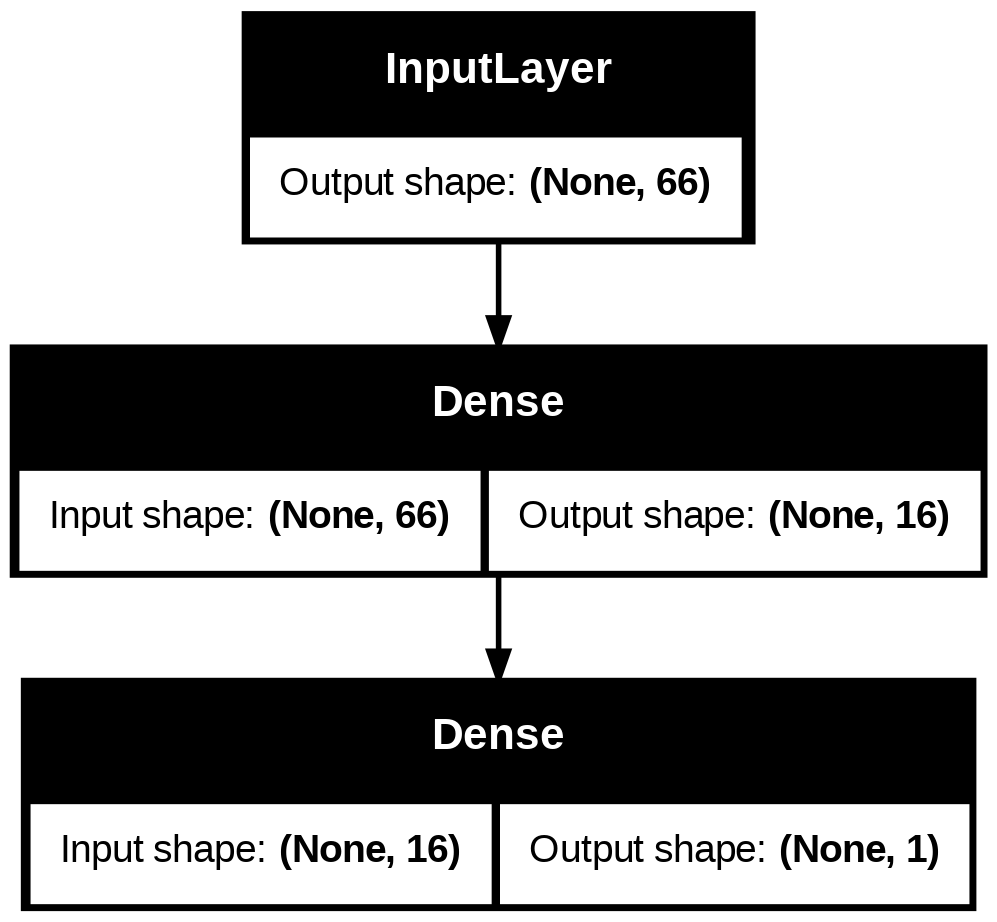

In [67]:
plot_model(model, show_shapes=True, to_file='init_model.png')

In [68]:
epochs = 10
history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset)

Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 0.4942 - FalseNegatives: 2.4082 - FalsePositives: 479.6939 - Precision: 0.3938 - Recall: 0.9954 - acc: 0.3942 - loss: 0.7264 - val_AUC: 0.4763 - val_FalseNegatives: 32.0000 - val_FalsePositives: 261.0000 - val_Precision: 0.4055 - val_Recall: 0.8476 - val_acc: 0.4175 - val_loss: 0.7013
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.4924 - FalseNegatives: 113.2041 - FalsePositives: 304.8367 - Precision: 0.4014 - Recall: 0.7236 - acc: 0.4671 - loss: 0.6986 - val_AUC: 0.4811 - val_FalseNegatives: 177.0000 - val_FalsePositives: 49.0000 - val_Precision: 0.4024 - val_Recall: 0.1571 - val_acc: 0.5507 - val_loss: 0.6905
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.4848 - FalseNegatives: 297.6122 - FalsePositives: 40.4490 - Precision: 0.3170 - Recall: 0.0745 - acc: 0.5726 - loss: 0.6878 - val_AUC: 0.4951 - val_FalseNegatives: 210.0000 - val_FalsePositives: 0.0000e+00 - val_Precision: 0.0000e+00 - val_Recall: 0.00

In [69]:
history.history.keys()

dict_keys(['AUC', 'FalseNegatives', 'FalsePositives', 'Precision', 'Recall', 'acc', 'loss', 'val_AUC', 'val_FalseNegatives', 'val_FalsePositives', 'val_Precision', 'val_Recall', 'val_acc', 'val_loss'])

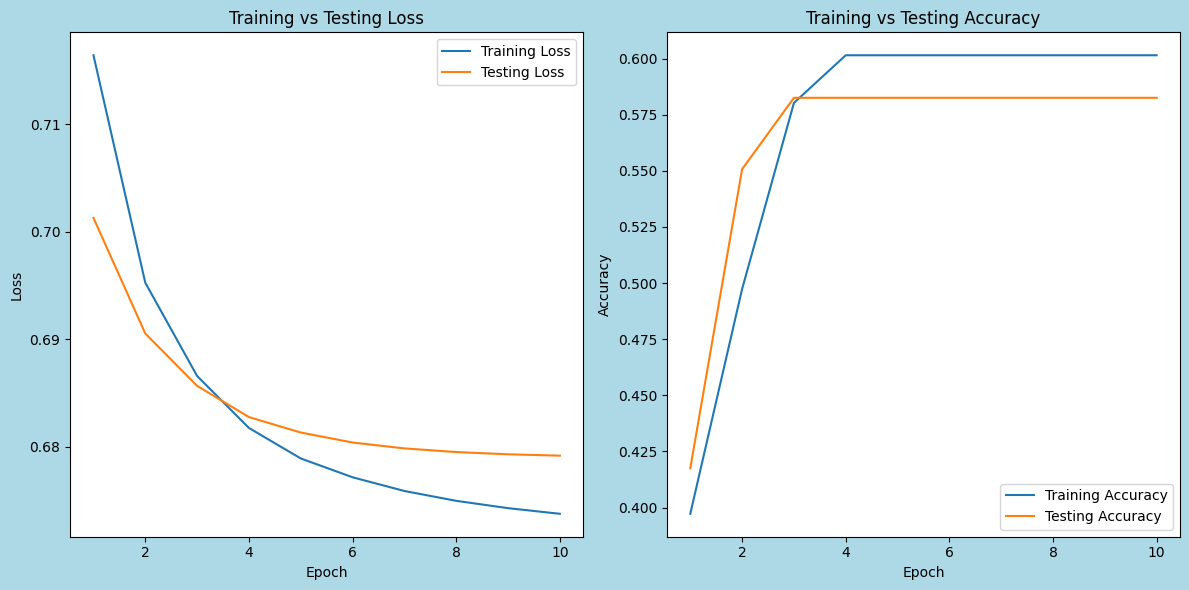

In [70]:
training_plots(epochs, history)

Current model looks to be overfitting based on the testing loss diverging from the decreasing training loss. There is still much opportunity to explore improvements.

In [71]:
np.mean(history.history['loss'], axis=0)

np.float64(0.6834943532943726)

In [72]:
validation_metrics(model, test_dataset, "Base: 1 Hidden Layer 16 Neurons")

{'Base: 1 Hidden Layer 16 Neurons': {'val loss': '0.679', 'val accuracy': '0.583', 'val f1': '0.000', 'val auc': '0.507', 'val precision': '0.000', 'val recall': '0.000', 'val false negatives': '0', 'val false positives': '210'}}


With an AUC around 0.5, we are better off with randomly guessing the class. The accurary and precision are poor.

Let's run many models with random combinations of hyperparameters that we can use to see where we should be focusing our time.

This style of experimenting was inspired by Johannes Kröpfl

https://github.com/johannes-kroepfl-97/Water-Quality-Classification/blob/main/fnn_pytorch.ipynb

In [189]:
breadths = [1, 2, 3, 4, 5, 6, 7]
depths = [16, 32, 64, 128, 256, 512]
activations = ['relu', 'sigmoid', 'tanh', 'leaky_relu']
optimizers = ['sgd', 'adam', 'rmsprop']
loss_funs = ['binary_crossentropy']
dropout_rates = [0, 0.25, 0.5]
epochs = [10, 50, 100]
batch_sizes = [32, 64, 128]
test_sizes = [0.1, 0.25, 0.5]
learning_rates = [0.0001, 0.001, 0.01, 0.1]

hyperparameters = [breadths, depths, activations, optimizers, loss_funs, dropout_rates, epochs, batch_sizes, test_sizes, learning_rates]

In [190]:
for i in range(10):
  params = [np.random.choice(h) for h in hyperparameters]
  print(params)

[np.int64(4), np.int64(64), np.str_('tanh'), np.str_('sgd'), np.str_('binary_crossentropy'), np.float64(0.25), np.int64(10), np.int64(32), np.float64(0.1), np.float64(0.001)]
[np.int64(5), np.int64(32), np.str_('leaky_relu'), np.str_('sgd'), np.str_('binary_crossentropy'), np.float64(0.5), np.int64(10), np.int64(32), np.float64(0.5), np.float64(0.001)]
[np.int64(4), np.int64(32), np.str_('relu'), np.str_('rmsprop'), np.str_('binary_crossentropy'), np.float64(0.25), np.int64(10), np.int64(128), np.float64(0.25), np.float64(0.001)]
[np.int64(4), np.int64(64), np.str_('tanh'), np.str_('rmsprop'), np.str_('binary_crossentropy'), np.float64(0.0), np.int64(100), np.int64(64), np.float64(0.25), np.float64(0.0001)]
[np.int64(2), np.int64(512), np.str_('tanh'), np.str_('adam'), np.str_('binary_crossentropy'), np.float64(0.0), np.int64(100), np.int64(128), np.float64(0.1), np.float64(0.01)]
[np.int64(3), np.int64(16), np.str_('tanh'), np.str_('sgd'), np.str_('binary_crossentropy'), np.float64(0.

In [75]:
params[0].item()

2

In [76]:
params[2].item()

'sigmoid'

In [77]:
params[7].item()

64

In [194]:
num_experiments = 200

def model_experiments(num_experiments, hyperparameters):

  results = []

  for i in range(num_experiments):
    params = [np.random.choice(h) for h in hyperparameters]

    breadth = params[0].item()
    depth = params[1].item()
    activation = params[2].item()
    optimizer = params[3].item()
    loss_fun = params[4].item()
    dropout_rate = params[5].item()
    epoch = params[6].item()
    batch = params[7].item()
    test_size = params[8].item()
    learning_rates = params[9].item()

    if optimizer == 'sgd':
      optimizer_fun = keras.optimizers.SGD(learning_rate=learning_rates)
    if optimizer == 'adam':
      optimizer_fun = keras.optimizers.Adam(learning_rate=learning_rates)
    if optimizer == 'rmsprop':
      optimizer_fun = keras.optimizers.RMSprop(learning_rate=learning_rates)

    #set up dictionary of model parameters
    model_parameters = {
        'Experiment': i+1,
        'breadth': breadth,
        'depth': depth,
        'activation': activation,
        'optimizer': optimizer,
        'loss_fun': loss_fun,
        'dropout_rate': dropout_rate,
        'epochs': epoch,
        'batch': batch,
        'test_size': test_size,
        'learning_rate': learning_rates,
        'accuracy': 0,
        'loss': 0,
        'auc': 0,
        'precision': 0,
        'recall': 0,
        'false_negatives': 0,
        'false_positives': 0,
        'f1score': 0
    }

    print(f'\nModel parameters: {model_parameters}')

    #create trainign and testing datasets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=test_size, random_state=42)
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch)
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch)

    #build the model using the randomly generated model parameter combos
    input = keras.Input(shape=(X_train.shape[-1],))
    x = layers.Dense(depth, activation=activation)(input)
    x = layers.Dropout(dropout_rate)(x)
    for i in range(breadth-1):
      x = layers.Dense(depth, activation=activation)(x)
      x = layers.Dropout(dropout_rate)(x)

    output = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs=input, outputs=output)
    model.compile(loss=loss_fun, optimizer=optimizer_fun, metrics=metrics)

    #train model
    history = model.fit(train_dataset, epochs=epoch, verbose=0)

    #evaluate model
    loss, accuracy, auc, precision, recall, false_positives, false_negatives  = model.evaluate(test_dataset, verbose=0)

    if precision + recall == 0:
      f1 = 0
    else:
      f1 = 2 * (precision * recall) / (precision + recall)

    #replace accuracy in model parameter dictionary
    model_parameters['accuracy'] = accuracy
    model_parameters['loss'] = loss
    model_parameters['auc'] = auc
    model_parameters['precision'] = precision
    model_parameters['recall'] = recall
    model_parameters['false_negatives'] = false_negatives
    model_parameters['false_positives'] = false_positives
    model_parameters['f1score'] = f1


    #append model parameters to results list
    results.append(model_parameters)

    print(f'Accuracy: {accuracy:.4f} | Loss: {loss:.3f} | F1: {f1:.4f} | Precision: {precision:.3f} | Recall: {recall:.3f} | AUC: {auc:.4f}')

    tf.keras.backend.clear_session()

  return results


In [195]:
results = model_experiments(num_experiments, hyperparameters)


Model parameters: {'Experiment': 1, 'breadth': 2, 'depth': 512, 'activation': 'leaky_relu', 'optimizer': 'adam', 'loss_fun': 'binary_crossentropy', 'dropout_rate': 0.25, 'epochs': 100, 'batch': 32, 'test_size': 0.1, 'learning_rate': 0.1, 'accuracy': 0, 'loss': 0, 'auc': 0, 'precision': 0, 'recall': 0, 'false_negatives': 0, 'false_positives': 0, 'f1score': 0}
Accuracy: 0.6436 | Loss: 2.678 | F1: 0.2340 | Precision: 0.733 | Recall: 0.139 | AUC: 0.5995

Model parameters: {'Experiment': 2, 'breadth': 5, 'depth': 512, 'activation': 'sigmoid', 'optimizer': 'sgd', 'loss_fun': 'binary_crossentropy', 'dropout_rate': 0.25, 'epochs': 10, 'batch': 32, 'test_size': 0.1, 'learning_rate': 0.1, 'accuracy': 0, 'loss': 0, 'auc': 0, 'precision': 0, 'recall': 0, 'false_negatives': 0, 'false_positives': 0, 'f1score': 0}
Accuracy: 0.6089 | Loss: 0.680 | F1: 0.0000 | Precision: 0.000 | Recall: 0.000 | AUC: 0.5000

Model parameters: {'Experiment': 3, 'breadth': 1, 'depth': 16, 'activation': 'relu', 'optimize

In [196]:
#let's view the top 10 model parameter combos and see if we can set some hyperparameters in stone for later experiments

results.sort(key=lambda x: x['accuracy'], reverse=True)
ballpark_params = results[0:10]
ballpark_params

[{'Experiment': 41,
  'breadth': 1,
  'depth': 16,
  'activation': 'leaky_relu',
  'optimizer': 'adam',
  'loss_fun': 'binary_crossentropy',
  'dropout_rate': 0.0,
  'epochs': 50,
  'batch': 64,
  'test_size': 0.1,
  'learning_rate': 0.01,
  'accuracy': 0.6930692791938782,
  'loss': 0.6227954030036926,
  'auc': 0.7003704905509949,
  'precision': 0.707317054271698,
  'recall': 0.3670886158943176,
  'false_negatives': 50.0,
  'false_positives': 12.0,
  'f1score': 0.48333333611488316},
 {'Experiment': 86,
  'breadth': 5,
  'depth': 16,
  'activation': 'leaky_relu',
  'optimizer': 'rmsprop',
  'loss_fun': 'binary_crossentropy',
  'dropout_rate': 0.0,
  'epochs': 50,
  'batch': 32,
  'test_size': 0.1,
  'learning_rate': 0.01,
  'accuracy': 0.6930692791938782,
  'loss': 0.6174996495246887,
  'auc': 0.6973860263824463,
  'precision': 0.7575757503509521,
  'recall': 0.3164556920528412,
  'false_negatives': 54.0,
  'false_positives': 8.0,
  'f1score': 0.44642856604495673},
 {'Experiment': 152,


In [197]:
experiment_1_results = results
#experiment_1_results

In [198]:
#pickle experiment_1_results
import pickle

with open('experiment_1_results.pkl', 'wb') as f:
    pickle.dump(experiment_1_results, f)

<Axes: title={'center': 'Accuracy Distribution for First Set of Random Experiments'}, ylabel='Count'>

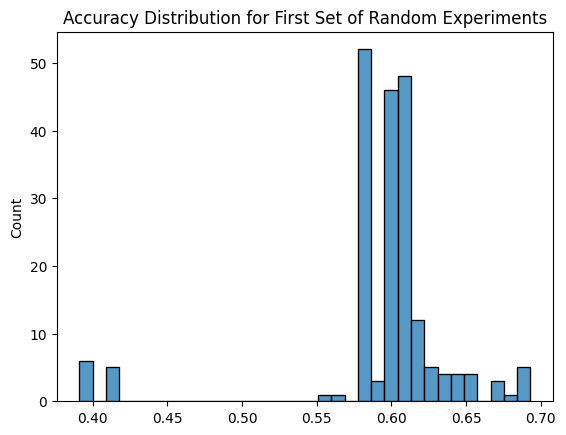

In [199]:
#let's see what the accuracy distribution looks like in this set of experiments
accuracies = [r['accuracy'] for r in experiment_1_results]
plt.title('Accuracy Distribution for Randomly Generated Models')
sns.histplot(accuracies)

In [201]:
print(f'Mean accuracy: {np.mean(accuracies):.4f}')

Mean accuracy: 0.5950


#let's see the top models based on precision


In [202]:
#let's sort experiment_1_results for the highest precision

experiment_1_results.sort(key=lambda x: x['precision'], reverse=True)
experiment_1_results[0:10]

[{'Experiment': 85,
  'breadth': 5,
  'depth': 256,
  'activation': 'leaky_relu',
  'optimizer': 'sgd',
  'loss_fun': 'binary_crossentropy',
  'dropout_rate': 0.5,
  'epochs': 10,
  'batch': 32,
  'test_size': 0.1,
  'learning_rate': 0.0001,
  'accuracy': 0.6138613820075989,
  'loss': 0.6872156858444214,
  'auc': 0.49583205580711365,
  'precision': 1.0,
  'recall': 0.012658228166401386,
  'false_negatives': 78.0,
  'false_positives': 0.0,
  'f1score': 0.025000000620784703},
 {'Experiment': 135,
  'breadth': 2,
  'depth': 32,
  'activation': 'leaky_relu',
  'optimizer': 'adam',
  'loss_fun': 'binary_crossentropy',
  'dropout_rate': 0.0,
  'epochs': 50,
  'batch': 32,
  'test_size': 0.5,
  'learning_rate': 0.1,
  'accuracy': 0.6033797264099121,
  'loss': 0.7236873507499695,
  'auc': 0.5742141008377075,
  'precision': 1.0,
  'recall': 0.0024999999441206455,
  'false_negatives': 399.0,
  'false_positives': 0.0,
  'f1score': 0.004987531060867821},
 {'Experiment': 16,
  'breadth': 2,
  'dept

Let's base our final model on Run 97 as it had a decent accuracy, good rpecision and relatively high recall.

In [217]:
#pull in data
url = 'https://raw.githubusercontent.com/JGasior-AI/WaterPotabilityDeepLearning/refs/heads/main/water_potability_featureengineered2.csv'
df = pd.read_csv(url)

#split into features and label
X = df.drop('Potability', axis=1).values
y = df['Potability'].values
X = np.array(X)
y = np.array(y)

#normalize X data
scaler = MinMaxScaler()
scaler.fit(X)
scaler.data_max_
X_scaled = scaler.transform(X)

#split data using 10% test size
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42)

#batch data and convert to tensor
batch = 128
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch)

In [224]:
input = keras.Input(shape=(X_train.shape[-1],))

x = layers.Dense(256, activation='leaky_relu')(input) #layer 1
x = layers.Dropout(0.25)(x)

x = layers.Dense(128, activation='leaky_relu')(x) #layer 2
x = layers.Dropout(0.25)(x)

output = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=input, outputs=output)

optimizer = keras.optimizers.RMSprop(learning_rate=0.01)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=metrics)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - AUC: 0.4964 - FalseNegatives: 280.1875 - FalsePositives: 222.8750 - Precision: 0.4101 - Recall: 0.4371 - acc: 0.5112 - loss: 2.0416 - val_AUC: 0.4507 - val_FalseNegatives: 79.0000 - val_FalsePositives: 0.0000e+00 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_acc: 0.6089 - val_loss: 0.6781
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.4972 - FalseNegatives: 415.6250 - FalsePositives: 20.0000 - Precision: 0.4398 - Recall: 0.0306 - acc: 0.5885 - loss: 0.6836 - val_AUC: 0.4764 - val_FalseNegatives: 79.0000 - val_FalsePositives: 0.0000e+00 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_acc: 0.6089 - val_loss: 0.7069
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.5093 - FalseNegatives: 364.9375 - FalsePositives: 83.5625 - Precision: 0.4285 - Recall: 0.1729 - acc: 0.5759 - loss: 0.6932 - val_AUC: 0.4866 - val_FalseNegatives: 79.0000 - val_FalsePositives: 0.0000e+00 - val_Precision: 0.00

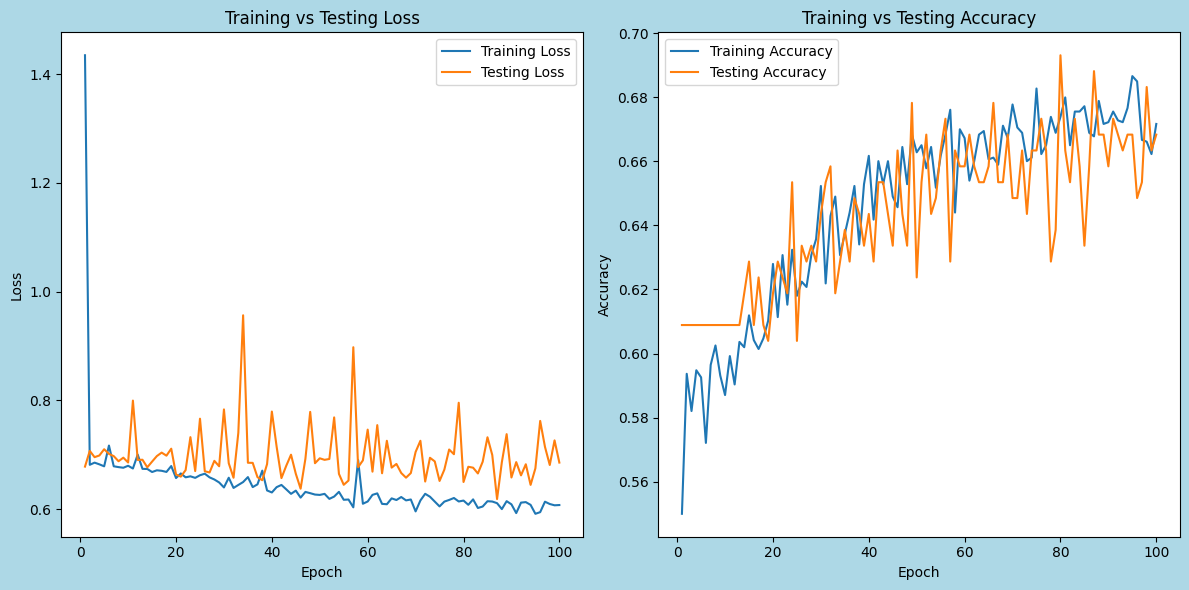

In [225]:
epochs = 100
history = model.fit(train_dataset, epochs=epochs, validation_data=(X_test, y_test))
training_plots(epochs, history)

In [226]:
loss, accuracy, auc, precision, recall, false_positives, false_negatives = model.evaluate(test_dataset, verbose=0)

if precision + recall == 0:
  f1 = 0
else:
  f1 = 2 * (precision * recall) / (precision + recall)

print(f'Accuracy: {accuracy:.4f} | Loss: {loss:.3f} | F1: {f1:.4f} | Precision: {precision:.3f} | Recall: {recall:.3f} | AUC: {auc:.4f} | False Positives { false_positives} | False Negatives {false_negatives}')

Accuracy: 0.6683 | Loss: 0.685 | F1: 0.2796 | Precision: 0.929 | Recall: 0.165 | AUC: 0.6591 | False Positives 1.0 | False Negatives 66.0


In [227]:
#pickle model as these results looks relatively good for the dataset

with open('model_v1.pkl', 'wb') as f:
    pickle.dump(model, f)

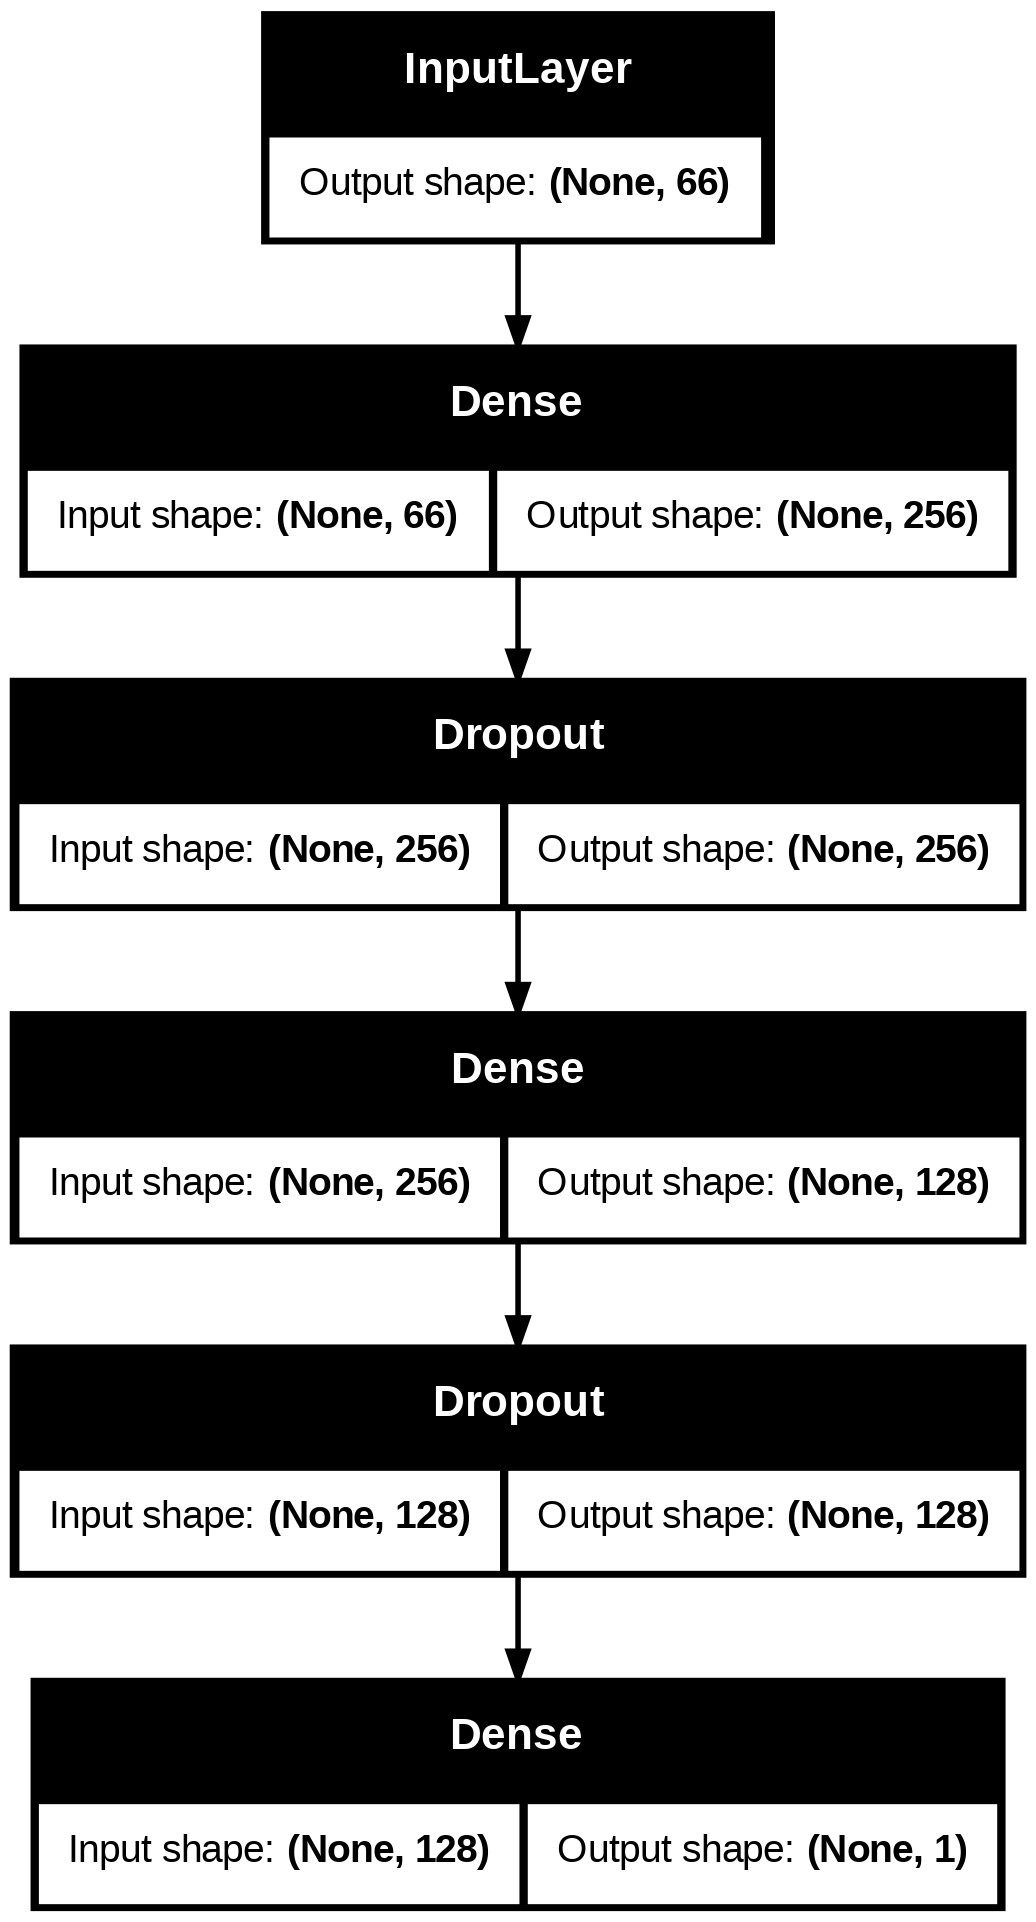

In [228]:
plot_model(model, show_shapes=True, to_file='final_model.png')

In [229]:
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 66)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 256)            │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,356 (392.02 KB)

 Trainable params: 50,177 (196.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 50,179 (196.02 KB)

# Data Scaling vs Normalization

In [238]:
url = "https://raw.githubusercontent.com/JGasior-AI/WaterPotabilityDeepLearning/refs/heads/main/water_potability_featureengineered2.csv"
df = pd.read_csv(url)

#split into features and label
X = df.drop('Potability', axis=1).values
y = df['Potability'].values
X = np.array(X)
y = np.array(y)

#scale X data
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

#split data using 10% test size
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42)

#batch data and convert to tensor
batch = 128
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch)



In [239]:
input = keras.Input(shape=(X_train.shape[-1],))

x = layers.Dense(256, activation='leaky_relu')(input) #layer 1
x = layers.Dropout(0.25)(x)

x = layers.Dense(128, activation='leaky_relu')(x) #layer 2
x = layers.Dropout(0.25)(x)

output = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=input, outputs=output)

optimizer = keras.optimizers.RMSprop(learning_rate=0.01)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=metrics)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - AUC: 0.5196 - FalseNegatives: 259.5625 - FalsePositives: 229.3125 - Precision: 0.4264 - Recall: 0.4206 - acc: 0.5285 - loss: 1.3009 - val_AUC: 0.5463 - val_FalseNegatives: 67.0000 - val_FalsePositives: 14.0000 - val_Precision: 0.4615 - val_Recall: 0.1519 - val_acc: 0.5990 - val_loss: 0.9934
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.6160 - FalseNegatives: 256.1250 - FalsePositives: 150.8750 - Precision: 0.5397 - Recall: 0.4010 - acc: 0.6123 - loss: 0.7538 - val_AUC: 0.5569 - val_FalseNegatives: 65.0000 - val_FalsePositives: 19.0000 - val_Precision: 0.4242 - val_Recall: 0.1772 - val_acc: 0.5842 - val_loss: 0.8458
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.6226 - FalseNegatives: 249.9375 - FalsePositives: 159.5625 - Precision: 0.5300 - Recall: 0.4228 - acc: 0.6086 - loss: 0.6933 - val_AUC: 0.5657 - val_FalseNegatives: 65.0000 - val_FalsePositives: 16.0000 - val_Precision: 0.4667 - val_Recall: 0.1772

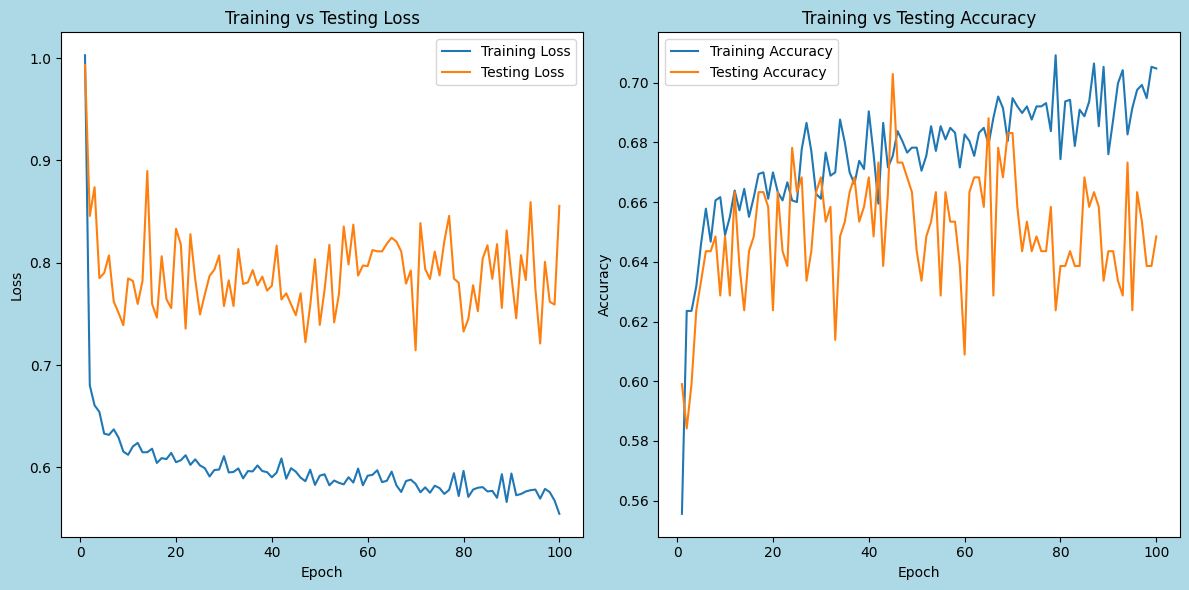

In [240]:
epochs = 100
history = model.fit(train_dataset, epochs=epochs, validation_data=(X_test, y_test))
training_plots(epochs, history)

In [241]:
loss, accuracy, auc, precision, recall, false_positives, false_negatives = model.evaluate(test_dataset, verbose=0)

if precision + recall == 0:
  f1 = 0
else:
  f1 = 2 * (precision * recall) / (precision + recall)

print(f'Accuracy: {accuracy:.4f} | Loss: {loss:.3f} | F1: {f1:.4f} | Precision: {precision:.3f} | Recall: {recall:.3f} | AUC: {auc:.4f} | False Positives { false_positives} | False Negatives {false_negatives}')

Accuracy: 0.6485 | Loss: 0.856 | F1: 0.4892 | Precision: 0.567 | Recall: 0.430 | AUC: 0.6727 | False Positives 26.0 | False Negatives 45.0


The scaling of data vs using min-max normalization causes overfitting. We will stick with min-max normalization

# Running Original Dataset

Let's see how our final model architecture would perform based on the original Kaggle dataset instead of the feature engineered dataset.

In [242]:
url = "https://raw.githubusercontent.com/JGasior-AI/WaterPotabilityDeepLearning/refs/heads/main/water_potability_cleaned.csv"
df = pd.read_csv(url)

#split into features and label
X = df.drop('Potability', axis=1).values
y = df['Potability'].values
X = np.array(X)
y = np.array(y)

#scale X data
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

#split data using 10% test size
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42)

#batch data and convert to tensor
batch = 128
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch)

In [243]:
input = keras.Input(shape=(X_train.shape[-1],))

x = layers.Dense(256, activation='leaky_relu')(input) #layer 1
x = layers.Dropout(0.25)(x)

x = layers.Dense(128, activation='leaky_relu')(x) #layer 2
x = layers.Dropout(0.25)(x)

output = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=input, outputs=output)

optimizer = keras.optimizers.RMSprop(learning_rate=0.01)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=metrics)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - AUC: 0.5140 - FalseNegatives: 433.8750 - FalsePositives: 0.4375 - Precision: 0.2188 - Recall: 6.7558e-04 - acc: 0.5893 - loss: 0.6858 - val_AUC: 0.4906 - val_FalseNegatives: 79.0000 - val_FalsePositives: 0.0000e+00 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_acc: 0.6089 - val_loss: 0.6843
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.5126 - FalseNegatives: 433.4375 - FalsePositives: 0.4375 - Precision: 0.2917 - Recall: 0.0014 - acc: 0.5895 - loss: 0.6837 - val_AUC: 0.4743 - val_FalseNegatives: 79.0000 - val_FalsePositives: 0.0000e+00 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_acc: 0.6089 - val_loss: 0.7023
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.5053 - FalseNegatives: 432.5625 - FalsePositives: 0.0000e+00 - Precision: 0.8750 - Recall: 0.0045 - acc: 0.5911 - loss: 0.6898 - val_AUC: 0.4847 - val_FalseNegatives: 79.0000 - val_FalsePositives: 0.0000e+00 - val_Precision:

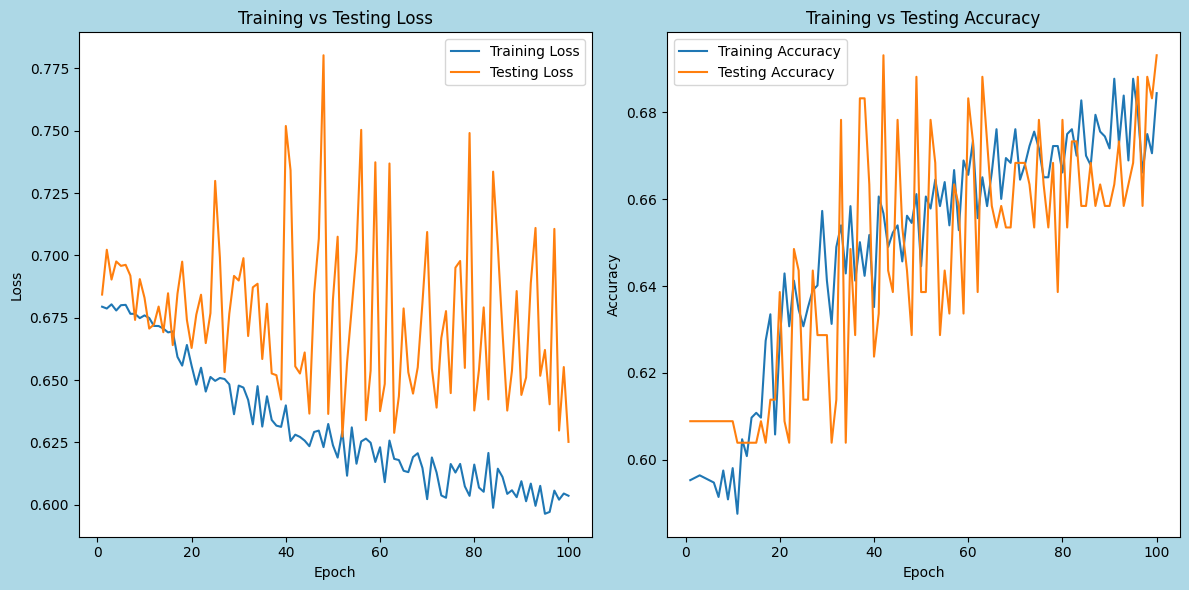

In [245]:
epochs = 100
history = model.fit(train_dataset, epochs=epochs, validation_data=(X_test, y_test))
training_plots(epochs, history)

In [246]:
loss, accuracy, auc, precision, recall, false_positives, false_negatives = model.evaluate(test_dataset, verbose=0)

if precision + recall == 0:
  f1 = 0
else:
  f1 = 2 * (precision * recall) / (precision + recall)

print(f'Accuracy: {accuracy:.4f} | Loss: {loss:.3f} | F1: {f1:.4f} | Precision: {precision:.3f} | Recall: {recall:.3f} | AUC: {auc:.4f} | False Positives { false_positives} | False Negatives {false_negatives}')

Accuracy: 0.6931 | Loss: 0.625 | F1: 0.4259 | Precision: 0.793 | Recall: 0.291 | AUC: 0.7156 | False Positives 6.0 | False Negatives 56.0
